In [36]:
%load_ext autoreload
%autoreload 2
 
import sys
sys.path.append('../src')
import xgboost as xgb
import pandas as pd
from features.UserJoin import UserJoin
from features.UserJoin import submit, diff, plt_month, plt_day, load_ids, info, infot
import config as C
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np


from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
from xgboost import plot_tree
import random
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import itertools
sns.set_style("ticks",{'axes.grid' : True})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ds = UserJoin()

In [3]:
def get_compare():
    compare = pd.concat([pd.DataFrame({'id': list(C.true_ids), 'label': 1}),
                         pd.DataFrame({'id': list(C.false_ids), 'label': 0}),
                         # pd.DataFrame({'id': list(C.ids_4_2), 'label': .5}),
                         # pd.DataFrame({'id': list(C.ids_4_2_V2), 'label': .5}),
                        #  pd.DataFrame({'id': list(C.ids_13_4), 'label': .692})
                         ])
    compare = compare.set_index('id')
    return compare

def score(ids):
    ids = list(ids)
    compare = get_compare()
    # print(f'共 {len(ids)} 忽略的 ', len(set(ids) - set(compare.index.values)))
    compare = compare.join(pd.DataFrame({'id': ids, 'pred': 1}).set_index('id')).fillna(0)
    compare = compare.reset_index()
    # sns.jointplot(data=compare, x='label', y='pred')
    # print(f'{np.mean((compare.pred - compare.label) ** 2):.3f}')
    # print(f'\t 共 {len(ids)} \t 对了 {len(set(ids) & C.true_ids)} \t 错了 {(compare.pred != compare.label).sum()} \t 未知 {len(set(ids) - C.true_ids - C.false_ids)}')
    print(f'\t 共 {len(ids)} \t 对了 {len(set(ids) & C.true_ids)} \t 错了 {len(set(ids) & C.false_ids)} \t 未知 {len(set(ids) - C.true_ids - C.false_ids)}')

    return compare

def aug2(df):
    idmax = df.index.max()

    d = df[df.IS_FLAG == 1]
    p = d[['pq_f', 'pq_p', 'pq_g', 'pq_z']] * .002

    newdfs = []
    for i in range(-400, 500):
        newd = d.copy()

        newd[['pq_f', 'pq_p', 'pq_g', 'pq_z']] = newd[['pq_f', 'pq_p', 'pq_g', 'pq_z']] + p*i
        newd = newd.reset_index()
        newd.id = newd.id + idmax*(i+6)
        newd = newd.set_index('id')

        newdfs.append(newd)

    return pd.concat(newdfs + [df])

def fjoin(df):
    user = ds.train[C.user_features]
    monthjoin = df.join(user, rsuffix='_mean')

    mean_cols = []
    for i in monthjoin.columns:
        if 'mean' in i:
            monthjoin[i.replace('mean', 'sub_mean')] = monthjoin[i.replace('_mean', '')] - monthjoin[i]
            mean_cols.append(i)

    monthjoin = monthjoin.drop(columns=mean_cols)

    monthjoin_features = [
        'pq_f',
        'pq_g',
        'pq_p',
        'pq_z',
        'pf',
        'pg',
        'pp',
        'p_f',
        'p_g',
        'f_g',
        'monthcv',
        # 'pq_f_mean',
        # 'pq_g_mean',
        # 'pq_p_mean',
        # 'pq_z_mean',
        # 'pp_mean',
        # 'pf_mean',
        # 'pg_mean',
        # 'p_f_mean',
        # 'p_g_mean',
        # 'f_g_mean',
        # 'monthcv_mean',

        'pq_f_sub_mean',
        'pq_g_sub_mean',
        'pq_p_sub_mean',
        'pq_z_sub_mean',
        'pp_sub_mean',
        'pf_sub_mean',
        'pg_sub_mean',
        'p_f_sub_mean',
        'p_g_sub_mean',
        'f_g_sub_mean',
        'monthcv_sub_mean',
    ]

    return monthjoin, monthjoin_features


def exp(features, df, params):
    x, x_val = df.loc[df.label != 'test', features], df.loc[df.label == 'test', features]
    y = df.loc[df.label != 'test', 'IS_FLAG']

    model = xgb.XGBClassifier(**params)
    model.fit(x, y)
    pred_y = model.predict(x)
    print((pred_y != y).sum())

    y_val = model.predict(x_val)
    pred_val = pd.DataFrame({'id': x_val.index.values, 'pred': y_val}).groupby('id').sum()
    pred_y = pd.DataFrame({'id': x.index.values, 'ym': df.loc[df.label != 'test'].ym.values, 'pred': pred_y, 'label': y.values})
    return pred_y, pred_val

    
def today_exp(params, aug=False, join=False):
    params['use_label_encoder'] = False

    t = ds.month
    # t = ds.month[ds.month.index.isin(ds.train1.index)]
    cols = C.month_features
    if aug:
        t = aug2(t)
    elif join:
        t, cols = fjoin(t)
    pred_y, pred_val = exp(cols, t, params)

    for i in range(10):
        t = pred_y[pred_y.pred == 1]
        t = t.groupby('id').count()
        ids = set(t[t.ym > i].index.values)
        # print(f' > {i}, {len(ids & set(C.minerids))} / {len(ids)}')

        if len(ids) < 10:
            break

    for i in range(22):
        ids = pred_val[pred_val.pred > i].index.values
        if len(ids) > 50:
            continue
        if len(ids) < 20:
            break
        print(f'val: > {i}', end=', ')
        score(ids)

    # return pred_val


In [19]:
# def score(ids):
#     print(f'\t 共 {len(ids)} \t 对了 {len(set(ids) & C.true_ids)} \t 错了 {len(set(ids) & C.false_ids)} \t 未知 {len(set(ids) - C.true_ids - C.false_ids)}')
#     return


# def exp(features, df, params):
#     x, x_val = df.loc[df.label != 'test', features], df.loc[df.label == 'test', features]
#     y = df.loc[df.label != 'test', 'IS_FLAG']

#     model = xgb.XGBClassifier(**params)
#     model.fit(x, y)
#     pred_y = model.predict(x)
#     print((pred_y != y).sum())

#     y_val = model.predict(x_val)
#     pred_val = pd.DataFrame({'id': x_val.index.values, 'pred': y_val}).groupby('id').sum()
#     pred_y = pd.DataFrame({'id': x.index.values, 'ym': df.loc[df.label != 'test'].ym.values, 'pred': pred_y, 'label': y.values})
#     return pred_y, pred_val


# def today_exp(params, aug=False, join=False):
#     params['use_label_encoder'] = False

#     t = ds.month
#     # t = ds.month[ds.month.index.isin(ds.train1.index)]
#     cols = C.month_features
#     pred_y, pred_val = exp(cols, t, params)

#     res = []
#     for i in range(22):
#         ids = set(pred_val[pred_val.pred > i].index.values)
#         res.append([i, len(ids & C.true_ids), len(ids & C.false_ids), len(ids - C.true_ids - C.false_ids)])
#     return res


# params = {
#     'max_depth': [3, 5, 6, 8, 10],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200, 300, 500],
#     'colsample_bytree': [0.3, 0.4, 0.6, 0.8, 1],
#     'subsample': [0.4, 0.8, 1]
# }

# dfs = []
# for max_depth, learning_rate, n_estimators, colsample_bytree, subsample in tqdm(itertools.product(params['max_depth'],
#                                                                                                     params['learning_rate'],
#                                                                                                     params['n_estimators'],
#                                                                                                     params['colsample_bytree'],
#                                                                                                     params['subsample'])):
#     p = {
#         'max_depth': max_depth,
#         'n_estimators': n_estimators,
#         'learning_rate': learning_rate,
#         'colsample_bytree': colsample_bytree,
#         'subsample': subsample,
#     }
#     res = today_exp(p)
#     for i in res:
#         p['gt'] = i[0]
#         p['right_miner'] = i[1]
#         p['wrong_miner'] = i[2]
#         p['unknown'] = i[3]

#         dfs.append(pd.DataFrame(p, index=[0]))


#     if len(dfs) > 3:
#         break
# df = pd.concat(dfs)
# df.to_csv('test.csv')


0it [00:00, ?it/s]

[17:20:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0it [00:02, ?it/s]

171


In [9]:
# 在29跑的结果
df = pd.read_csv('../src/test.csv')
t = df.groupby(['max_depth', 'n_estimators', 'learning_rate', 'colsample_bytree', 'subsample', 'gt']).first()
t = t[t.total != 0]
# t[t.right_miner > 28]
t['precision'] = t.right_miner / t.total
t.sort_values('precision', ascending=False)

total  \
max_depth n_estimators learning_rate colsample_bytree subsample gt          
6         200          0.20          1.0              1.0       20      4   
          300          0.01          1.0              0.8       18      8   
                                     0.8              1.0       19      8   
                                                                20      7   
                                     1.0              0.4       16     15   
...                                                                   ...   
          100          0.20          0.3              0.4       0     198   
8         200          0.20          0.3              0.4       0     199   
6         200          0.20          0.3              0.4       0     199   
10        100          0.10          0.8              0.8       0     205   
6         200          0.01          1.0              1.0       0     205   

                                                                    right_miner  \
max_depth n_estimators learning_rate colsample_bytree subsample gt                
6         200          0.20          1.0              1.0       20            4   
          300          0.01          1.0              0.8       18            8   
                                     0.8              1.0       19            8   
                                                                20            7   
                                     1.0              0.4       16           15   
...                                                                         ...   
          100          0.20          0.3              0.4       0            29   
8         200          0.20          0.3              0.4       0            29   
6         200          0.20          0.3              0.4       0            29   
10        100          0.10          0.8              0.8       0            29   
6         200          0.01          1.0              1.0       0            29   

                                                                    wrong_miner  \
max_depth n_estimators learning_rate colsample_bytree subsample gt                
6         200          0.20          1.0              1.0       20            0   
          300          0.01          1.0              0.8       18            0   
                                     0.8              1.0       19            0   
                                                                20            0   
                                     1.0              0.4       16            0   
...                                                                         ...   
          100          0.20          0.3              0.4       0            13   
8         200          0.20          0.3              0.4       0            13   
6         200          0.20          0.3              0.4       0            13   
10        100          0.10          0.8              0.8       0            13   
6         200          0.01          1.0              1.0       0            13   

                                                                    unknown  \
max_depth n_estimators learning_rate colsample_bytree subsample gt            
6         200          0.20          1.0              1.0       20        0   
          300          0.01          1.0              0.8       18        0   
                                     0.8              1.0       19        0   
                                                                20        0   
                                     1.0              0.4       16        0   
...                                                                     ...   
          100          0.20          0.3              0.4       0       156   
8         200          0.20          0.3              0.4       0       157   
6         200          0.20          0.3              0.4       0       157   
10        100          0.10          

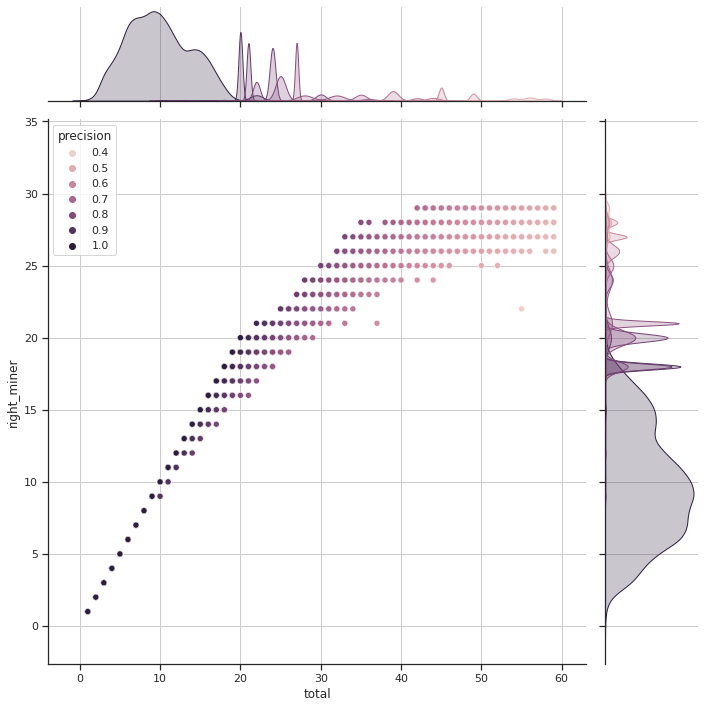

In [37]:
sns.jointplot(data=t[t.total < 60], x='total', y='right_miner', hue='precision', height=10)

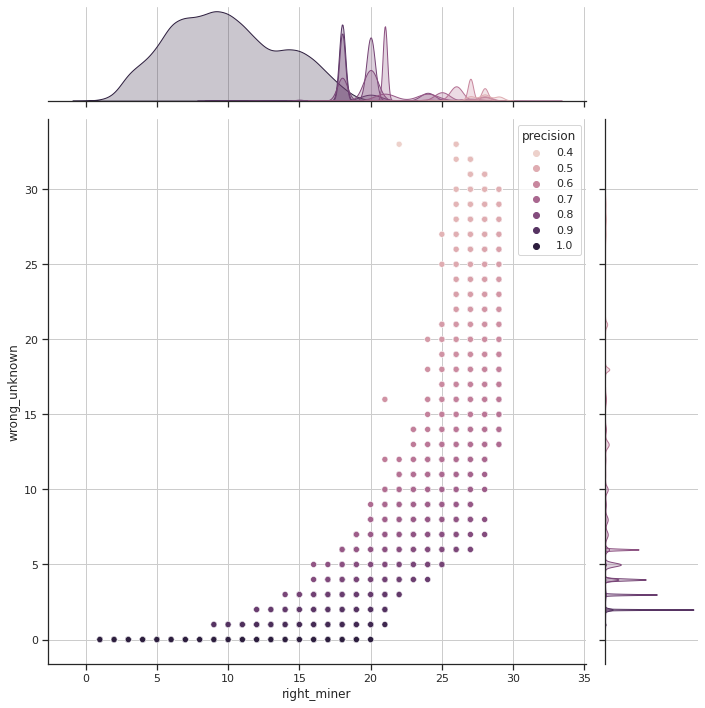

In [38]:
t['wrong_unknown'] = t.wrong_miner + t.unknown
sns.jointplot(data=t[t.total < 60], x='right_miner', y='wrong_unknown', hue='precision', height=10)

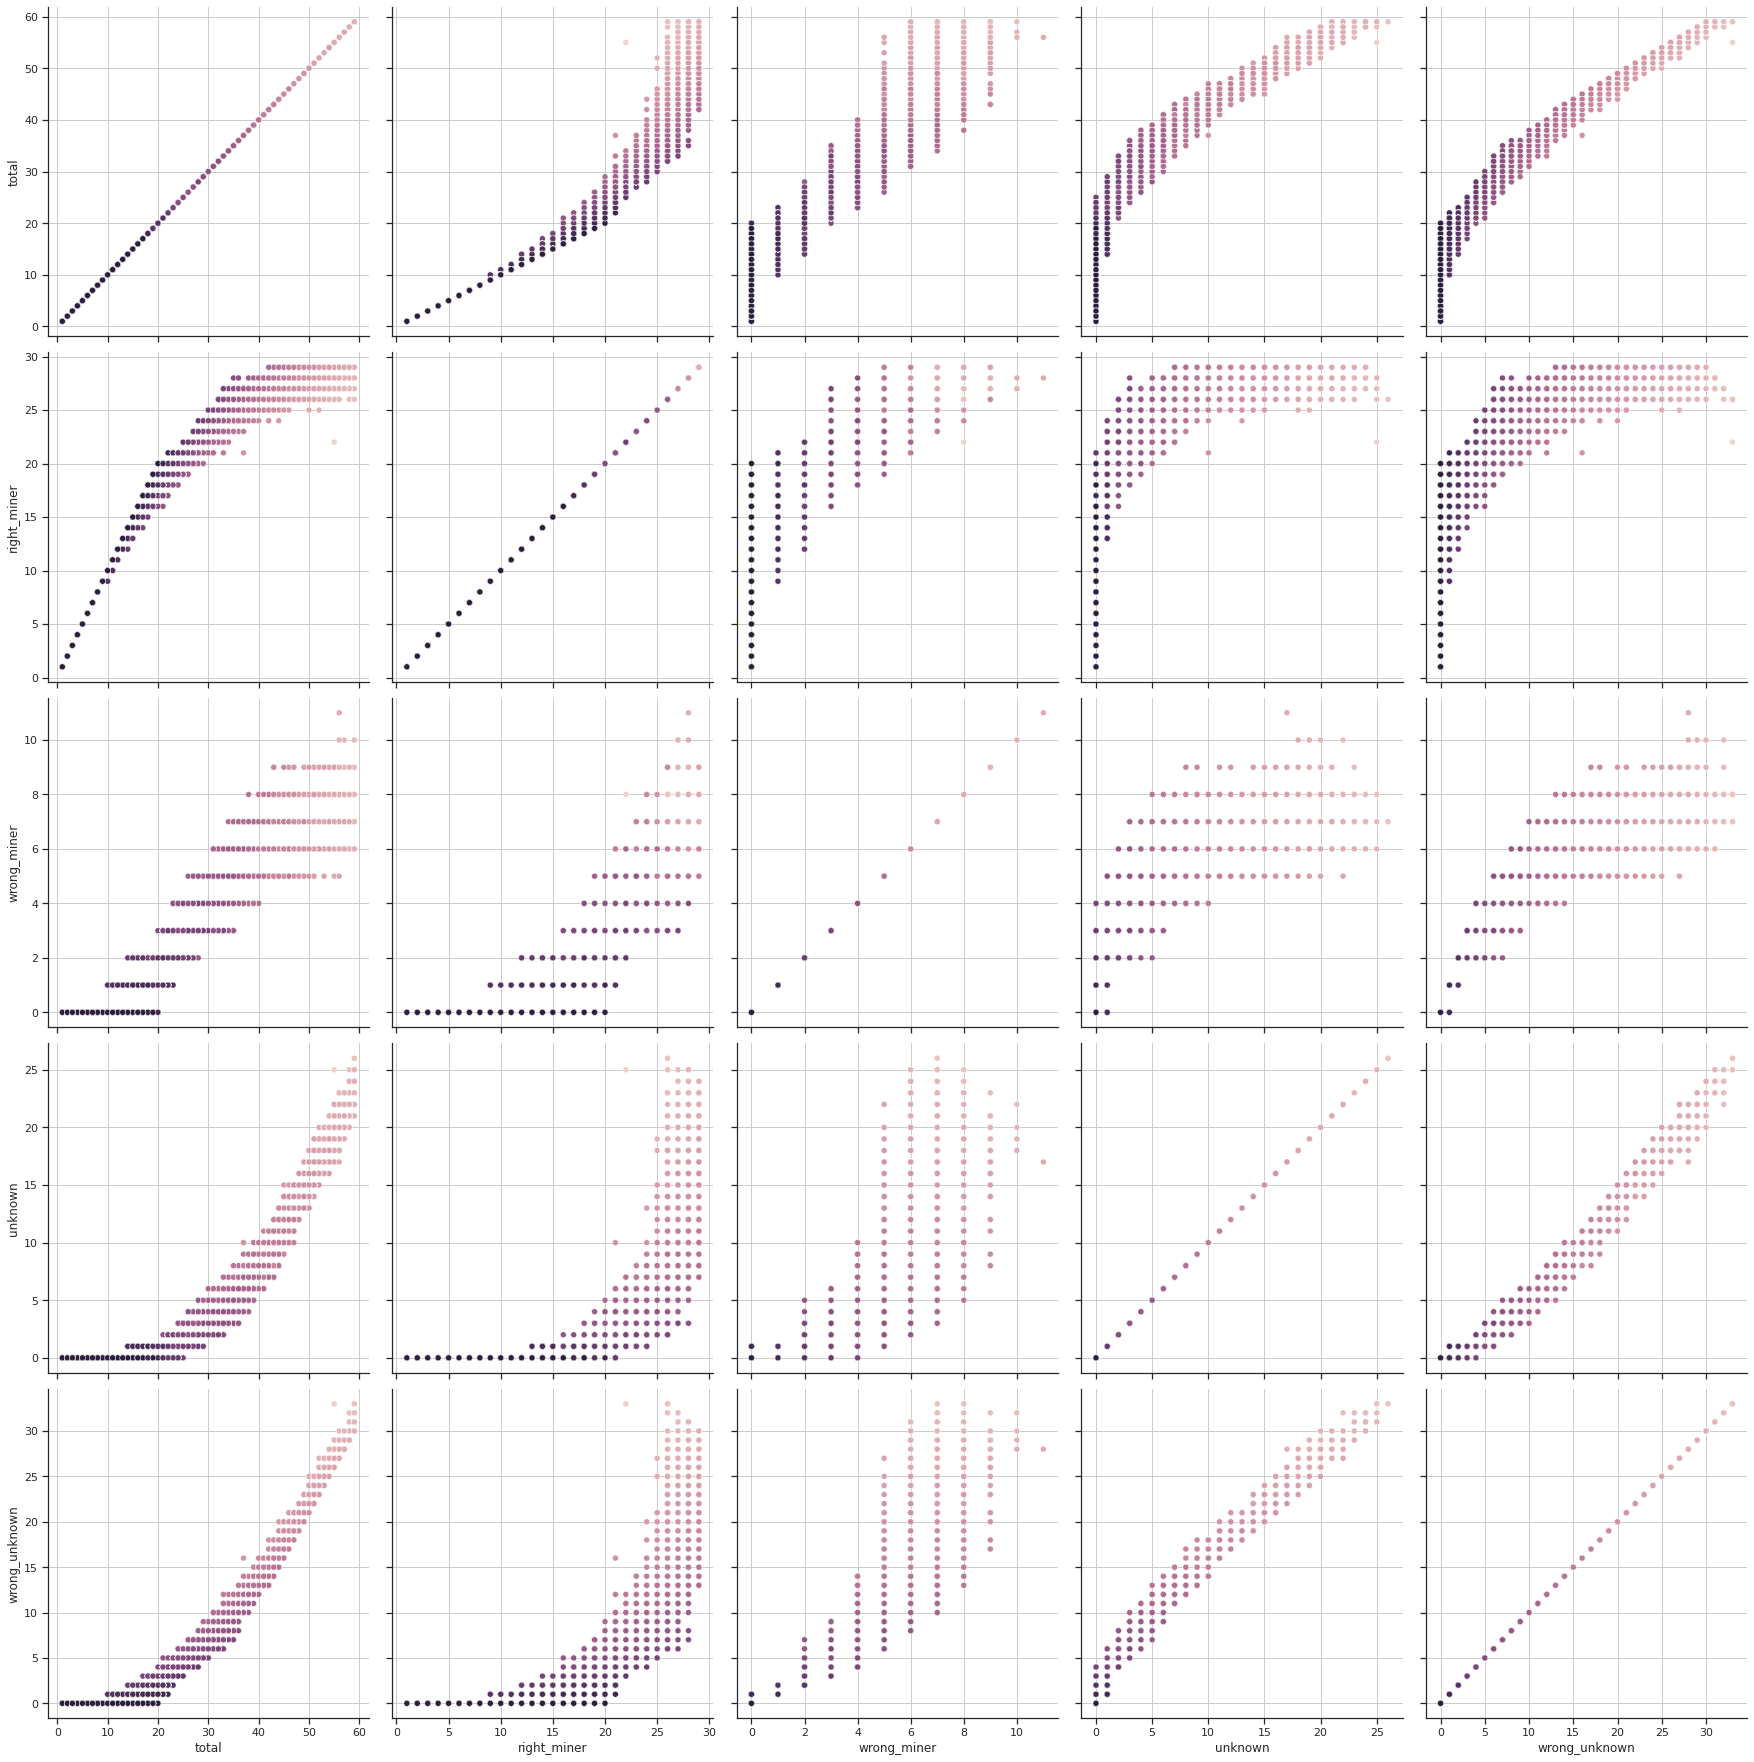

In [40]:
g = sns.PairGrid(t[t.total < 60], height=5, hue='precision')
# g.map_diag(sns.histplot)
g.map(sns.scatterplot)
# g.add_legend(title="", adjust_subtitles=True)